# Notebook 02 - Distributions

*Martin Vonk - 2022*

This notebooks shows an example of choosing the right distribution of the precipitation or precipitation-excess. Note that this notebooks focusses on visually interpreting this data. There are also tests to check the validity of a distribution. However these are not currently implemented in this package.

## Required packages

In [1]:
import spei as si  # si for standardized index
import pandas as pd
import scipy.stats as scs
import matplotlib.pyplot as plt

## Load time series

We use time series from the Netherlands and obtain them from the python package [Pastas](https://github.com/pastas/pastas). The precipitation and precipitation-excess (precipitation - potential evaporation) time series are accumulated on with a 30D rolling sum.

In [2]:
fileurl = "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data"
rain = (
    pd.read_csv(f"{fileurl}/rain_nb1.csv", index_col=0, parse_dates=True)
    .squeeze()
    .multiply(1e3)
)  # to mm
evap = (
    pd.read_csv(f"{fileurl}/evap_nb1.csv", index_col=0, parse_dates=True)
    .squeeze()
    .multiply(1e3)
)  # to mm

# accumulate time series
f = 30
prec = rain.rolling(f"{f}D", min_periods=f).sum().dropna()
pe = (rain - evap).dropna().rolling(f"{f}D", min_periods=f).sum().dropna()

## Plot precipitation distributions

The internal plot.dist method can be used to plot the (cumulative) histogram and the scipy.stats distribution fit. The given distribution using a [maximum likelihood estimate](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.fit.html#scipy.stats.rv_continuous.fit) where a negative log-likelihood function is minimized. It is important to visually check if the (cumulative) density function is actually valid for the (cumulative) histogram of the monthly data of each time series.

Let's first try that for the gamma distribution.

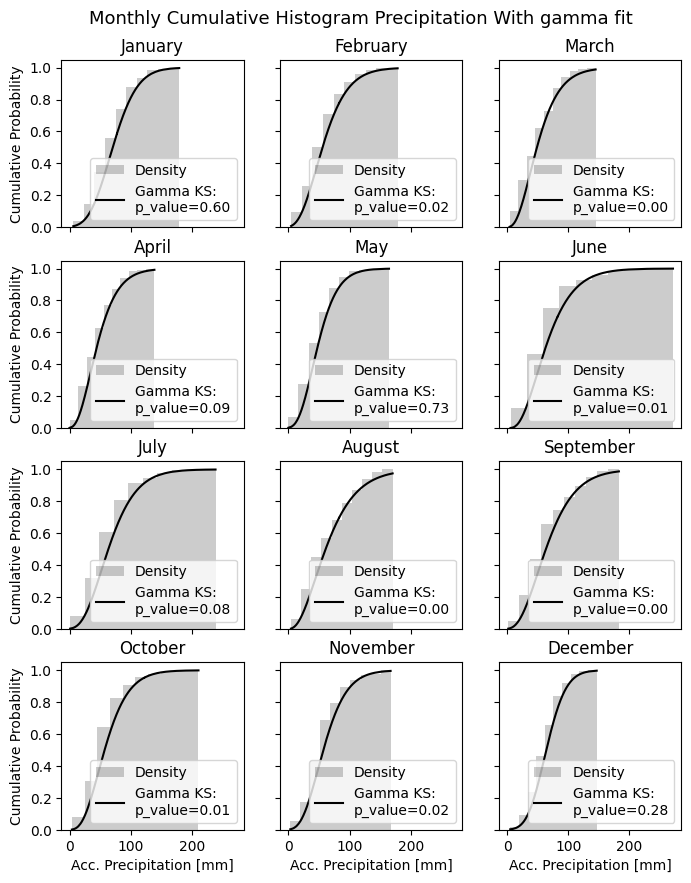

In [3]:
dist = scs.gamma
axs = si.plot.dist(prec, dist, cumulative=True)
plt.suptitle(
    f"Monthly Cumulative Histogram Precipitation With {dist.name} fit",
    y=0.93,
    fontsize=13,
)
[ax.set_xlabel("Acc. Precipitation [mm]") for ax in axs[-1]];

Let's try and fit a Pearson3 distribution and plot the probability density instead of the cumulative probability.

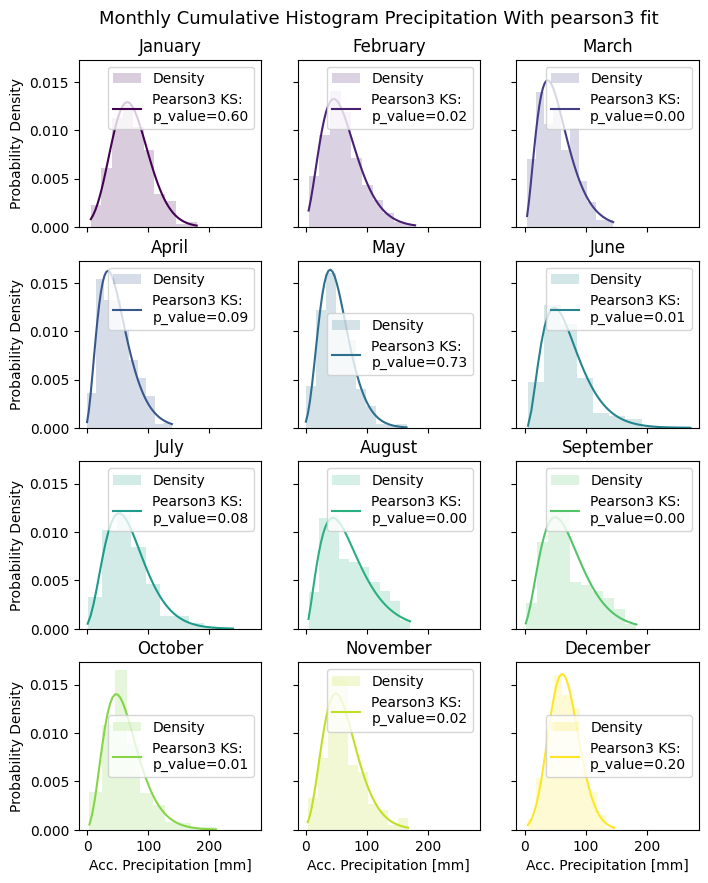

In [4]:
dist = scs.pearson3
axs = si.plot.dist(prec, dist, cmap="viridis", cumulative=False)
plt.suptitle(
    f"Monthly Cumulative Histogram Precipitation With {dist.name} fit",
    y=0.93,
    fontsize=13,
)
[ax.set_xlabel("Acc. Precipitation [mm]") for ax in axs[-1]];

As can be seen for both distributions they do not fit perfectly on the observed precipitation amounts. Not finding the appropriate distribution is one of the big uncertainties of this standardized index method. However not a perfect fit does not mean these distributions are not fit-for-purpose.

## Plot precipitation-excess distributions

Let's plot the three most comonly used distributions for the SPEI:
- fisk (log-logistic)
- lognorm (lognormal)
- pearson3 (Pearson III)

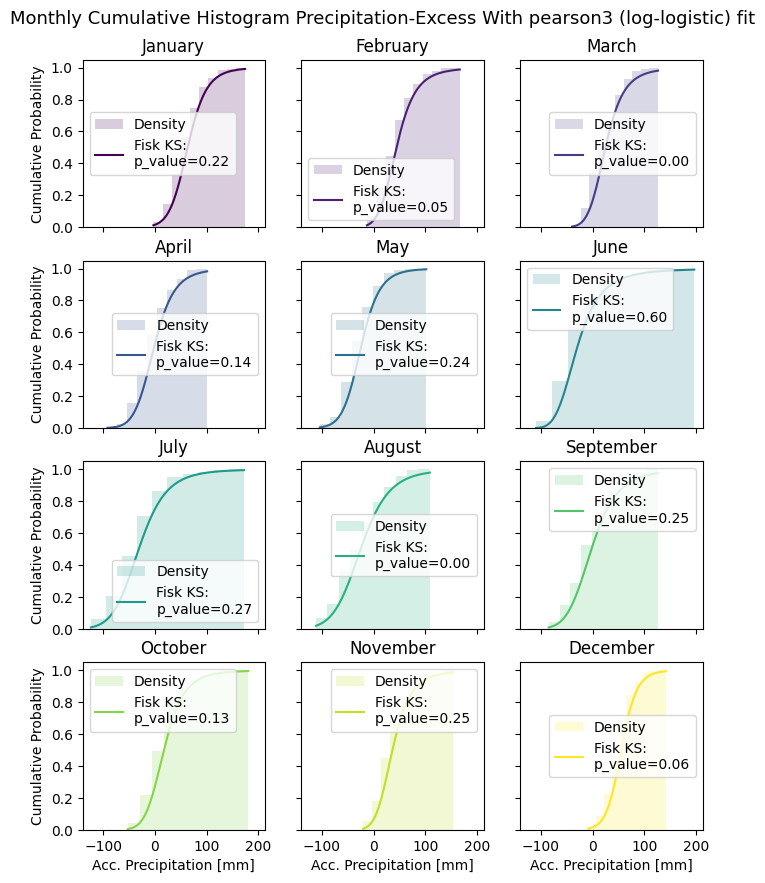

In [5]:
axs = si.plot.dist(pe, scs.fisk, cmap="viridis", cumulative=True)
plt.suptitle(
    f"Monthly Cumulative Histogram Precipitation-Excess With {dist.name} (log-logistic) fit",
    y=0.93,
    fontsize=13,
)
[ax.set_xlabel("Acc. Precipitation [mm]") for ax in axs[-1]];

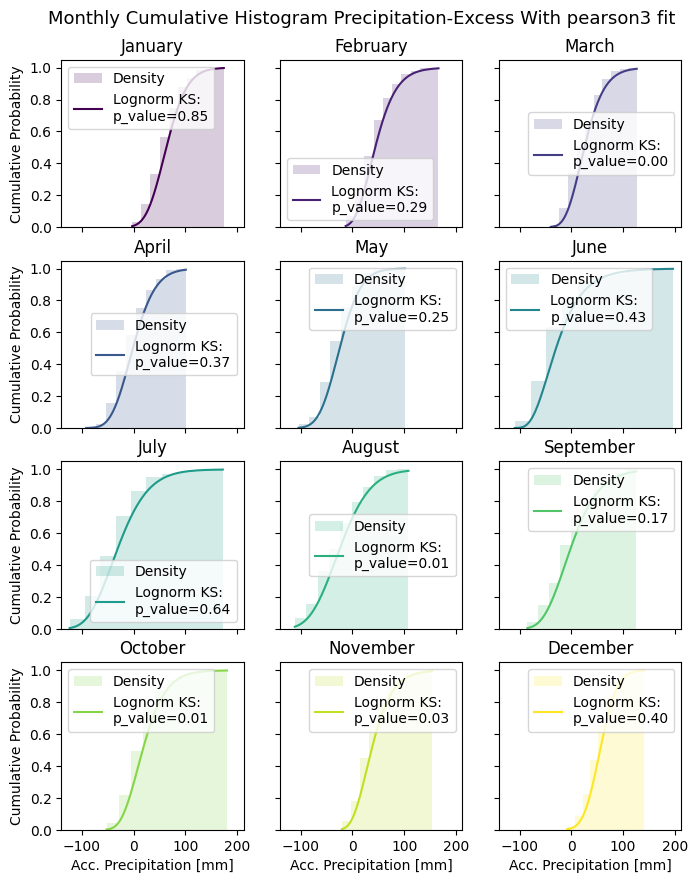

In [6]:
axs = si.plot.dist(pe, scs.lognorm, cmap="viridis", cumulative=True)
plt.suptitle(
    f"Monthly Cumulative Histogram Precipitation-Excess With {dist.name} fit",
    y=0.93,
    fontsize=13,
)
[ax.set_xlabel("Acc. Precipitation [mm]") for ax in axs[-1]];

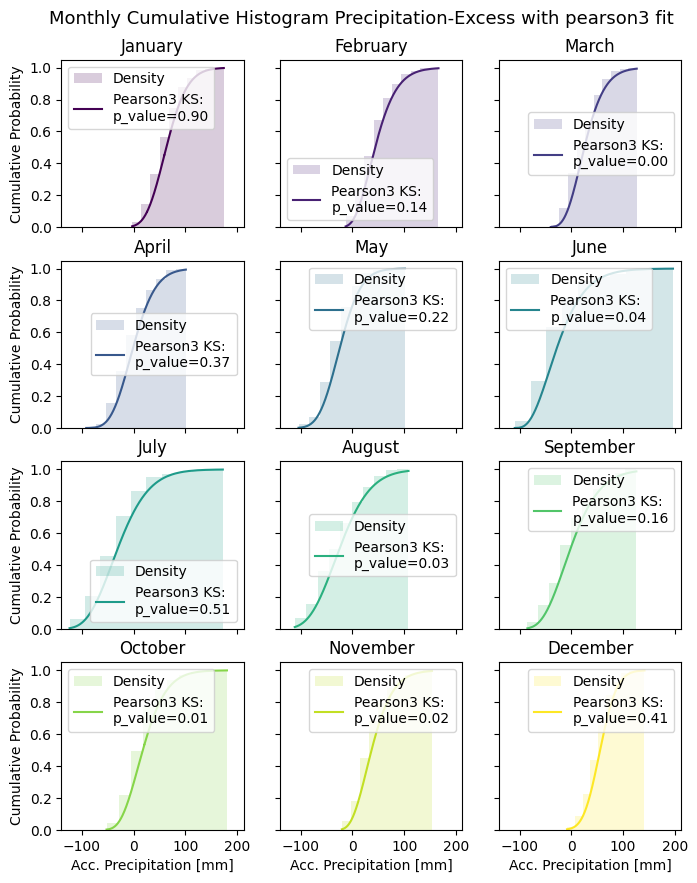

In [7]:
axs = si.plot.dist(pe, scs.pearson3, cmap="viridis", cumulative=True)
plt.suptitle(
    f"Monthly Cumulative Histogram Precipitation-Excess with {dist.name} fit",
    y=0.93,
    fontsize=13,
)
[ax.set_xlabel("Acc. Precipitation [mm]") for ax in axs[-1]];